## Synthesizing data for Indian Art Music predominant pitch extraction

### 1. Introduction

This notebook is hosting the code that I wrote for the study of Indian Art Music predominant melody extraction. Especifically, the goal of the code in this notebook is to synthesize audio data from F0 annotations to generate ground-truth for training and evaluating the models that are to be developed. 

This notebook has been designed to be reproducible from any Google Drive user account, but you must run it using Google Colab. The externals are automatically installed, downloaded and unzipped, and compiled.

You can see the Python module version of this code in this repository: [genisplaja/predominantIAMmelody](https://github.com/genisplaja/predominantIAMmelody) (not up-to-date with this notebook yet).

#### Used tools:
* [MELODIA](https://www.justinsalamon.com/melody-extraction.html) by Justin Salamon and Emilia Gómez
* [PredominantMelodyMakam](https://github.com/sertansenturk/predominantmelodymakam) by Sertan Sentürk (based on Justin Salamon and Emilia Gómez's [MELODIA](https://www.justinsalamon.com/melody-extraction.html)).
* Adapted version of [sms-tools](https://github.com/MTG/sms-tools) by MTG
* [Essentia](https://github.com/MTG/essentia) by MTG

#### Abstract of the study:
Predominant pitch extraction is a task within the field of MIR (Music Information Retrieval) which have been widely studied and even so, it has not been solved yet. One of the main problems which is clearly obstructing the advance of the research in this topic is the lack of well-annotated and correctly time-aligned data. This matter is even more emphasized when it comes to non-mainstream World music traditions (such as Indian Art Music), which tend to receive less attention than Western music in MIR research. Predominant pitch data is essential for a wide range of Indian Art Music melodic analysis works. For that reason, researchers focusing on Indian Art Music melodic tasks typically extract the pitch tracks with state-of-the-art methods, apply optional post-processing techniques, and use this data for their studies, assuming that these data suffers from various problems. In this work, we propose an analysis/synthesis framework to generate correct Indian Art Music predominant pitch annotations, using the brand new Saraga Dataset (compiled within the CompMusic research project from the Carnatic and Hindustani corpora).

**Please contact me if you have any problem with this notebook: genis.plaja01@estudiant.upf.edu**

### 2. Setting the environment

First of all, mount your Google Drive.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g5AMjnQIFG2fsr-BQ7r1eG6LubkSc3voSUXmOtUjbBHOfynfatTlyw
Mounted at /content/drive


Installing and importing all the dependencies needed during the code.

In [2]:
!pip install gdown

import importlib.util
if importlib.util.find_spec('essentia') is None:
    !pip install essentia

if importlib.util.find_spec('spleeter') is None:
    !pip install spleeter

import gdown
import sys
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import essentia.standard as estd
from scipy.signal import get_window
from scipy.io.wavfile import write
from scipy.ndimage import gaussian_filter1d

import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 12.0MB 286kB/s 
     |████████████████████████████████| 51kB 2.7MB/s 
     |████████████████████████████████| 20.1MB 1.3MB/s 
     |████████████████████████████████| 320.4MB 50kB/s 
     |████████████████████████████████| 10.5MB 49.2MB/s 
     |████████████████████████████████| 71kB 6.5MB/s 
     |████████████████████████████████| 460kB 40.9MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 71kB 6.7MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:

Downloading my adapted version of sms_tools software using gdown and links from my own Google Drive account.

Also, downloading the Saraga Test Set: this is a test that I have curated myself, trying to use different recordings with different characteristics: high and low pitches, male and female singers, simultaneous and question/response violin structure... so that we increade the validity of our approach in terms of how representative is the data we are using. You could use *mirdata* to import the Saraga Carnatic Dataset, but you would need to wait for a lot of time for the whole dataset to download and import, so I am creating this sub set also for a better and easier reproducibility of the experiment.

In [3]:
url = 'https://drive.google.com/uc?id=1-zSqdIWc7hGO0x2bVY6jiFrqz9eJF8nM'
output = 'sms_tools.zip'
gdown.download(url, output, quiet=True) 
!unzip /content/sms_tools.zip
if os.path.exists('/content/__MACOSX'):
    !rm -r /content/__MACOSX
!rm /content/sms_tools.zip

url = 'https://drive.google.com/uc?id=1CObXtJmr4t6bqjrMDUUF2CJ-YkS5QBpT'
output = 'saraga_test_set.zip'
gdown.download(url, output, quiet=True) 
!unzip /content/saraga_test_set.zip
if os.path.exists('/content/__MACOSX'):
    !rm -r /content/__MACOSX
!rm /content/saraga_test_set.zip

Archive:  /content/sms_tools.zip
   creating: sms_tools/
  inflating: __MACOSX/._sms_tools    
  inflating: sms_tools/.DS_Store     
  inflating: __MACOSX/sms_tools/._.DS_Store  
   creating: sms_tools/models/
   creating: sms_tools/models_interface/
  inflating: sms_tools/models/spsModel.py  
  inflating: __MACOSX/sms_tools/models/._spsModel.py  
  inflating: sms_tools/models/sprModel.pyc  
  inflating: sms_tools/models/spsModel.pyc  
  inflating: sms_tools/models/hprModel.pyc  
  inflating: sms_tools/models/hpsModel.pyc  
  inflating: sms_tools/models/sprModel.py  
  inflating: __MACOSX/sms_tools/models/._sprModel.py  
  inflating: sms_tools/models/.DS_Store  
  inflating: __MACOSX/sms_tools/models/._.DS_Store  
  inflating: sms_tools/models/dftModel.pyc  
  inflating: sms_tools/models/harmonicModel.py  
  inflating: __MACOSX/sms_tools/models/._harmonicModel.py  
  inflating: sms_tools/models/sineModel.py  
  inflating: __MACOSX/sms_tools/models/._sineModel.py  
  inflating: sms_tool

Installing Sentürk's predominant melody algorithm and compiling adapted version of sms_tools software.

In [4]:
# Import S. Sentürk's Melodia version
!pip install git+https://github.com/sertansenturk/predominantmelodymakam.git

# Compile sms-tools modules
!python '/content/sms_tools/models/utilFunctions_C/compileModule.py' build_ext --inplace

  Cloning https://github.com/sertansenturk/predominantmelodymakam.git to /tmp/pip-req-build-c15lbgw_
  Running command git clone -q https://github.com/sertansenturk/predominantmelodymakam.git /tmp/pip-req-build-c15lbgw_
  Created wheel for predominantmelodymakam: filename=predominantmelodymakam-1.3.0-cp37-none-any.whl size=17782 sha256=c67704a80cb2d96ec21add801878d233ccdbb4fbddbc90cf230ea76c11ea09bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-id7jrenk/wheels/cc/87/6e/f2f91a6553014661600cfd96f80f6defb9aa3a86e40179c526
Successfully built predominantmelodymakam
running build_ext
skipping '/content/sms_tools/models/utilFunctions_C/cutilFunctions.c' Cython extension (up-to-date)
building 'utilFunctions_C' extension
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/content
creating build/temp.linux-x86_64-3.7/content/sms_tools
creating build/temp.linux-x86_64-3.7/content/sms_tools/models
creating build/temp.linux-x86_64-3.7/content/sms_tools/model

### 3. Getting into the code


Import util functions (in this case, basically an **interpolation step to fill the gaps** in the pitch tracks created by glottal sounds or consonants (Gulati et al, 2016).

In [5]:
def interpolate_below_length(arr, val, gap):
    """
    Interpolate gaps of value, <val> of
    length equal to or shorter than <gap> in <arr>
    :param arr: Array to interpolate
    :type arr: np.array
    :param val: Value expected in gaps to interpolate
    :type val: number
    :param gap: Maximum gap length to interpolate, gaps of <val> longer than <g> will not be interpolated
    :type gap: number
    :return: interpolated array
    :rtype: np.array
    """
    s = np.copy(arr)
    is_zero = s == val
    cumsum = np.cumsum(is_zero).astype('float')
    diff = np.zeros_like(s)
    diff[~is_zero] = np.diff(cumsum[~is_zero], prepend=0)
    for i, d in enumerate(diff):
        if d <= gap:
            s[int(i-d):i] = np.nan
    interp = pd.Series(s).interpolate(method='linear', axis=0)\
                         .ffill()\
                         .bfill()\
                         .values
    return interp

The next cell loads the **functions to pre-process the audio and pitch tracks** extracted from the samples.

In [6]:
def pre_processing(fname, extracted_pitch, hop_size, sample_rate, pitch_preproc, voicing):

    # Load audio and adapt pitch length
    audio = estd.MonoLoader(filename=fname)()
    extracted_pitch = extracted_pitch[:-2]

    # Zero pad the audio so the length is multiple of 128
    if len(audio) % hop_size != 0:
        zero_pad = np.zeros(int((hop_size * np.ceil(len(audio) / hop_size))) - len(audio))
        audio = np.concatenate([audio, zero_pad])

    # Parsing time stamps and pitch values of the extracted pitch data
    time_stamps = [x[0] for x in extracted_pitch]
    pitch_values = [x[1] for x in extracted_pitch]
    gap_len = 250 * 0.001

    if pitch_preproc:
        # Interpolate gaps shorter than 250ms (Gulati et al, 2016)
        pitch_values = interpolate_below_length(arr=pitch_values, val=0.0, gap=(gap_len*sample_rate)/hop_size)
        # Smooth pitch track a bit
        pitch_values = gaussian_filter1d(pitch_values, sigma=3)

    if voicing:
        voiced_samples = []
        for sample in pitch_values:
            if sample > 0.0:
                voiced_samples = np.concatenate([voiced_samples, hop_size * [1]])
            else:
                voiced_samples = np.concatenate([voiced_samples, hop_size * [0]])

        # Set to 0 audio samples which are not voiced while detecting silent zone onsets
        audio_modif = audio.copy()
        silent_zone_on = 1
        silent_onsets = []
        for idx, voiced_sample in enumerate(voiced_samples):
            if voiced_sample == 0:
                audio_modif[idx] = 0.0
                if silent_zone_on == 0:
                    silent_onsets.append(idx)
                    silent_zone_on = 1
            else:
                if silent_zone_on == 1:
                    silent_onsets.append(idx)
                    silent_zone_on = 0

        # Remove first onset if first sample is voiced
        if voiced_samples[0] == 1:
            silent_onsets = silent_onsets[1:] if silent_onsets[0] == 0 else silent_onsets

        # A bit of fade out at sharp gaps
        for onset in silent_onsets:
            # Make sure that we don't run out of bounds
            if onset + hop_size < len(audio_modif):
                audio_modif[onset-(hop_size*6):onset+(hop_size*6)] = gaussian_filter1d(
                    audio_modif[onset-(hop_size*6):onset+(hop_size*6)], sigma=3
                )

        return audio_modif, pitch_values, time_stamps

    else:
        return audio, pitch_values, time_stamps


The next cell contains **the function to synthesize the audio** using a modified version of the Harmonic plus Stochastic model from sms-tools.

In [7]:
if '/content/sms_tools/models/' not in sys.path:
    sys.path.append('/content/sms_tools/models/')
from sms_tools.models import hpsModel as HPS

def synthesize(filtered_audio, pitch_track, sample_rate, parameters):

    # Get window for the stft
    w = get_window(parameters['window'], parameters['M'], fftbins=True)

    # Get harmonic content from audio using extracted pitch as reference
    hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(
        x=filtered_audio,
        f0=pitch_track,
        fs=sample_rate,
        w=w,
        N=parameters['N'],
        H=parameters['H'],
        t=parameters['t'],
        nH=parameters['nH'],
        minf0=parameters['minf0'],
        maxf0=parameters['maxf0'],
        f0et=parameters['f0et'],
        harmDevSlope=parameters['harmDevSlope'],
        minSineDur=parameters['minSineDur'],
        Ns=parameters['Ns'],
        stocf=parameters['stocf']
    )

    # Synthesize audio with generated harmonic content
    y, _, _ = HPS.hpsModelSynth(
        hfreq,
        hmag,
        hphase,
        stocEnv,
        parameters['Ns'],
        parameters['H'],
        sample_rate
    )

    return y, pitch_track

The next cell contains a **function which resumes and runs all the process to generate a track** from the available audio data. It extracts the pitch track from the raw vocal channel, it pre-processes it, and then in synthesizes a new audio using the extracted pitch and harmonic plus residual information, analyzed using the adapted version of sms-tools.

Please note that at this moment, Melodia is used for synthesis. Please follow the comment in the `generate_track` function to change to PMM for the synthesis step.

As seen in the previous cells, by setting the flag ```pitch_preproc``` you can chose whether to apply processing tecniques to the pitch or not, and by setting the flag ```voicing``` you can chose whether to set the unvoiced regions (taking the extracting pitch track as reference) of the audio to silence. For our final experiment and evaluation, we do preprocess the pitch track and we also apply voicing filtering, basically to avoid the summation of potentially unmatching signals on the areas where there is no voice.

Also, the flag ```use_mix``` can be used to use the mix track for the synthesis. However, the experiments have proven that setting this flag to True produces strong artifacts.



In [8]:
from predominantmelodymakam.predominantmelodymakam import PredominantMelodyMakam

def generate_track(filename, synth_parameters, pitch_preproc, voicing, use_mix):

    '''
    Currently using Melodia for synthesis. Uncomment following lines and comment
    from hop_size = 128 to the pitch unpacking line.
    '''

    # Running melody extraction with PMM
    #pmm = PredominantMelodyMakam()
    #output = pmm.run(fname=filename)

    # Organizing the output
    #pitch_pmm = output['pitch']
    #hop_size = output['settings']['hopSize']
    #sample_rate = output['settings']['sampleRate']

    # Running melody extraction with MELODIA
    hop_size = 128
    frame_size = 2048
    sample_rate = 44100
    audio = estd.EqloudLoader(filename=filename, sampleRate=sample_rate)()
    pitch_extractor = estd.PredominantPitchMelodia(frameSize=frame_size, hopSize=hop_size)
    est_freq, _ = pitch_extractor(audio)
    est_freq = np.append(est_freq, 0.0)
    est_time = np.linspace(0.0,len(audio)/sample_rate,len(est_freq))
    pitch = [[x, y] for x, y in zip(est_time, est_freq)]

    # Preprocessing analyzed audio and pitch
    audio, pitch_processed, time_stamps_processed = pre_processing(
        filename,
        pitch,
        hop_size,
        sample_rate,
        pitch_preproc=pitch_preproc,
        voicing=voicing,
    )

    # Get mix for synth (not really good results!!!)
    if use_mix:
        filename_to_synth = filename.replace(".wav", "_mix.wav") if use_mix is True else filename
        audio, _, _ = pre_processing(filename_to_synth, pitch, hop_size, sample_rate, voicing=voicing)

    # Add max and min F0 values at synthesis parameters
    synth_parameters.update({'minf0': min(pitch_processed) - 75})
    synth_parameters.update({'maxf0': max(pitch_processed) + 75})

    # Synthesize vocal track
    synthesized_audio, pitch_track = synthesize(audio, pitch_processed, sample_rate, synth_parameters)

    # Get accompaniment
    filename_mix = filename.replace(".wav", "_mix.wav")
    audio_loader = AudioAdapter.default()
    waveform, _ = audio_loader.load(filename_mix, sample_rate=sample_rate)
    prediction = separator.separate(waveform)

    # Dummy debugging
    #print(len(synthesized_audio))
    #print(len(time_stamps))
    #print(len(pitch_track))

    # Mixing synthesized vocals with isolated accompaniment
    mix_mono = prediction['accompaniment'].sum(axis=1) / 2
    mix_mono_processed = mix_mono[:len(synthesized_audio)+1]
    synthesized_audio_mix = [x*0.8 + y*0.2 for x, y in zip(synthesized_audio, mix_mono_processed)]

    # Write synthesized audio to file
    filename_idx = filename.split('/')[-1].replace('example', '').replace('.wav', '')
    filename_to_save = "/content/example" + filename_idx + ".wav"
    write(filename_to_save, sample_rate, np.array(synthesized_audio_mix))

    '''
    # Write txt annotation to file
    tmp_txt = tmp.replace("wav", "txt")
    pitchtrack_to_save = "/content/synth_" + tmp_txt
    with open(pitchtrack_to_save, 'w') as f:
        for i, j in zip(time_stamps_processed, pitch_track):
            f.write("{}, {}\n".format(i, j))
    '''

    print(filename, 'sythesized with exit!')

    return synthesized_audio_mix, pitch_track, time_stamps_processed    


**Next cell loads the test set.** It basically loads the files from the Saraga Test Set downloaded at the beginning of the process and trim them to certain length, to reduce the computation time. It also formats filenames to make file parsing easier into the functions.


In [9]:
# If you skip this line the plot doesn't work
%matplotlib inline 

import IPython.display as ipd
import shutil

from sms_tools.models import utilFunctions as UF
from sms_tools.models import harmonicModel as HM
from sms_tools.models import sineModel as SM
from sms_tools.models import stft
from sms_tools.models import dftModel as DFT

eps = np.finfo(float).eps

if os.path.exists('/content/saraga_examples/'):
    shutil.rmtree('/content/saraga_examples/', ignore_errors=True)

if not os.path.exists('/content/saraga_examples/'):
    os.mkdir('/content/saraga_examples/')

samples_dict = []
test_sample_length_s = 30
for idx, track in tqdm(enumerate(os.listdir('/content/saraga_test_set/'))):
    if 'multitrack' in track:
        if 'Chinnanchiru' not in track:
            # Get mix filename
            track_mix = track.replace('multitrack-vocal.mp3', 'mp3.mp3')

            # Load both vocal and mix
            audio = estd.MonoLoader(filename=os.path.join('/content/saraga_test_set', track), sampleRate=44100)()
            audio_mix = estd.MonoLoader(filename=os.path.join('/content/saraga_test_set', track_mix), sampleRate=44100)()

            # Trim audios to selected length (30 for the experiments)
            audio_trimmed = audio[:44100*test_sample_length_s]
            audio_mix_trimmed = audio_mix[:44100*test_sample_length_s]

            # Write standarized filenames for both audios
            filename = '/content/saraga_examples/example'+ str(idx) + '.wav'
            filename_mix = '/content/saraga_examples/example'+ str(idx) + '_mix.wav'

            # Save audios
            estd.MonoWriter(filename=filename)(audio_trimmed)
            estd.MonoWriter(filename=filename_mix)(audio_mix_trimmed)

            print('---')
            print(track)
            print(idx)
            print('---')


3it [00:01,  2.97it/s]

---
Purahara Nandana.multitrack-vocal.mp3
2
---


6it [00:07,  1.16it/s]

---
Paragu Matada.multitrack-vocal.mp3
5
---


7it [00:08,  1.11s/it]

---
Geeta Nayakan.multitrack-vocal.mp3
6
---


8it [00:10,  1.19s/it]

---
Seethamma.multitrack-vocal.mp3
7
---


10it [00:11,  1.06s/it]

---
Karunimpa Idi.multitrack-vocal.mp3
9
---


11it [00:14,  1.39s/it]

---
Gopi Gopala Bala.multitrack-vocal.mp3
10
---


17it [00:25,  1.53s/it]

---
Janakipathe Jaya Karunya Jaladhe.multitrack-vocal.mp3
16
---


18it [00:27,  1.68s/it]

---
Entha Muddo.multitrack-vocal.mp3
17
---


20it [00:29,  1.44s/it]

---
Kannallavo Swami.multitrack-vocal.mp3
19
---


21it [00:32,  1.96s/it]

---
Chidambara Natarajam.multitrack-vocal.mp3
20
---


22it [00:38,  3.28s/it]

---
Hiranmayeem.multitrack-vocal.mp3
21
---


25it [00:42,  2.66s/it]

---
Dinamani Vamsa.multitrack-vocal.mp3
24
---


27it [00:45,  2.35s/it]

---
Siddhi Vinayakam.multitrack-vocal.mp3
26
---


28it [00:45,  1.75s/it]

---
Pavamana Suthudu Mangalam.multitrack-vocal.mp3
27
---


29it [00:54,  3.91s/it]

---
Dorakuna.multitrack-vocal.mp3
28
---


31it [01:08,  4.73s/it]

---
Koluvamaregatha.multitrack-vocal.mp3
30
---


34it [01:17,  4.30s/it]

---
Parama Pavana Rama.multitrack-vocal.mp3
33
---


38it [01:18,  3.04s/it]

---
Shlokam - Shivah Shaktyayukto.multitrack-vocal.mp3
37
---


39it [01:21,  2.91s/it]

---
Jaya Jaya Janaki Kantha.multitrack-vocal.mp3
38
---


43it [01:32,  2.93s/it]

---
Shankari Shankuru.multitrack-vocal.mp3
42
---


44it [01:43,  5.12s/it]

---
Shlokham.multitrack-vocal.mp3
43
---


45it [01:44,  3.95s/it]

---
Sarasamukhi Sakala.multitrack-vocal.mp3
44
---


47it [01:44,  2.82s/it]

---
Shloka.multitrack-vocal.mp3
46
---


50it [02:02,  3.53s/it]

---
Rama Rama Guna Seema.multitrack-vocal.mp3
48
---
---
Vanajaksha Ninne Nammiti.multitrack-vocal.mp3
49
---


53it [02:04,  2.67s/it]

---
Eppadi Manam Thunindhadho.multitrack-vocal.mp3
52
---


54it [02:09,  3.57s/it]

---
Eramuni.multitrack-vocal.mp3
53
---


58it [02:12,  2.66s/it]

---
Bandadella Barali.multitrack-vocal.mp3
57
---


60it [02:13,  2.23s/it]

---
Vandalum.multitrack-vocal.mp3
59
---


### 4. Evaluate different pitch extraction algorithms with the generated data

Writing functions to run the different pitch extraction methods. The following algorithms are used (which are also the ones considered for the synthesis process):
* Melodia
* PredominantMelodyMakam

First of all, import mir_eval to evaluate the results.



In [10]:
import importlib.util
if importlib.util.find_spec('mir_eval') is None:
    !pip install mir_eval

import mir_eval

     |████████████████████████████████| 92kB 3.4MB/s 
  Created wheel for mir-eval: filename=mir_eval-0.6-cp37-none-any.whl size=96515 sha256=d45c8ba1fcc502d8946e50ac4672602a6a34417d58a810968134cbff6f76feca
  Stored in directory: /root/.cache/pip/wheels/49/ce/30/730fa72addf275e49d90683b01b3613048b4be3bf7ff8eb6ec
Successfully built mir-eval


Loading Spleeter main functions and creating the synthesis parameters configuration dictionary.

In [11]:
from spleeter.separator import Separator
from spleeter.audio.adapter import AudioAdapter

# Synthesis parameters (to be tuned!)
# max and min f0 values from parameters are computed from the extracted pitch
parameters = {
    'window': 'hanning',
    'M': 1001,
    'N': 4096,
    'Ns': 512,
    'H': 128,
    't': -90,
    'minSineDur': 0.001,
    'nH': 30,
    'f0et': 5.0,
    'harmDevSlope': 0.001,
    'stocf': 0.1,
}

**We start running the whole pipeline and evaluating Melodia.** This cell basically loads the audio files we trimmed and reorganized, and runs the whole pipeline on them, using the functions implementeed above. The scores for each track are appended into a score list, which will be used afterwards to build the boxplots for evaluation. The idea is to evaluate how the synthesized annotated data looks like by running predominant pitch extraction algorithms over these data and evaluating the results.

Please note that this function may take an hour or more, since it needs to run pitch extraction, Spleeter separation, analysis and synthesis through sms-tools and file reading and writing.

In [ ]:
# Declare separator
separator = Separator('spleeter:2stems')

def run_melodia(audio, sampleRate, frameSize, hopSize):

    # Extract the pitch curve
    # PitchMelodia takes the entire audio signal as input (no frame-wise processing is required)
    pitch_extractor = estd.PredominantPitchMelodia(frameSize=frameSize, hopSize=hopSize)
    est_freq, _ = pitch_extractor(audio)

    # Pitch is estimated on frames so compute frame time positions
    est_time = np.linspace(0.0,len(audio)/sampleRate,len(est_freq))

    return est_time, est_freq

# Run the generating function and evaluate the result for every track
scores_list = []
for track in tqdm(os.listdir('/content/saraga_examples/')):
    if 'mix' not in track:
        if 'example' in track:
            complete_filename = os.path.join('/content/saraga_examples/', track)

            print('===> synthesizing:', complete_filename)

            # Get synthesized audio and pitch track
            synthesized_audio, pitch_track, time_stamps = generate_track(
                filename=complete_filename,
                synth_parameters=parameters,
                pitch_preproc=True,
                voicing=True,
                use_mix=False,
            )

            # Run the algorithm
            est_time, est_freq = run_melodia(
                audio=synthesized_audio,
                sampleRate=44100,
                frameSize=parameters['N'],
                hopSize=parameters['H'],
            )

            # Evaluate output with mir_eval
            scores = mir_eval.melody.evaluate(
                np.array(time_stamps),
                np.array(pitch_track),
                np.array(est_time),
                np.array(est_freq),
            )

            scores_list.append(scores)
            print(scores)

  0%|          | 0/58 [00:00<?, ?it/s]

===> synthesizing: /content/saraga_examples/example33.wav
INFO:tensorflow:Apply unet for vocals_spectrogram
INFO:tensorflow:Apply unet for accompaniment_spectrogram
INFO:spleeter:Downloading model archive https://github.com/deezer/spleeter/releases/download/v1.4.0/2stems.tar.gz
INFO:spleeter:Validating archive checksum
INFO:spleeter:Extracting downloaded 2stems archive
INFO:spleeter:2stems model file(s) extracted
INFO:tensorflow:Restoring parameters from pretrained_models/2stems/model
/content/saraga_examples/example33.wav sythesized with exit!


  3%|▎         | 2/58 [01:50<51:21, 55.02s/it]

OrderedDict([('Voicing Recall', 0.9531301212717141), ('Voicing False Alarm', 0.15210203117619273), ('Raw Pitch Accuracy', 0.9192068174369059), ('Raw Chroma Accuracy', 0.9192068174369059), ('Overall Accuracy', 0.8899961300309598)])
===> synthesizing: /content/saraga_examples/example16.wav
/content/saraga_examples/example16.wav sythesized with exit!


  5%|▌         | 3/58 [03:29<1:02:37, 68.32s/it]

OrderedDict([('Voicing Recall', 0.6728291316526611), ('Voicing False Alarm', 0.40467753366406806), ('Raw Pitch Accuracy', 0.37557422969187676), ('Raw Chroma Accuracy', 0.41557422969187674), ('Overall Accuracy', 0.4055727554179567)])
===> synthesizing: /content/saraga_examples/example43.wav
/content/saraga_examples/example43.wav sythesized with exit!


 12%|█▏        | 7/58 [05:02<46:36, 54.83s/it]  

OrderedDict([('Voicing Recall', 0.946164199192463), ('Voicing False Alarm', 0.14900206469373709), ('Raw Pitch Accuracy', 0.9072678331090175), ('Raw Chroma Accuracy', 0.9072678331090175), ('Overall Accuracy', 0.8914473684210527)])
===> synthesizing: /content/saraga_examples/example57.wav
/content/saraga_examples/example57.wav sythesized with exit!


 14%|█▍        | 8/58 [06:34<54:49, 65.79s/it]

OrderedDict([('Voicing Recall', 0.8943285179240236), ('Voicing False Alarm', 0.38636363636363635), ('Raw Pitch Accuracy', 0.8562065275548422), ('Raw Chroma Accuracy', 0.8563402889245586), ('Overall Accuracy', 0.7890866873065016)])
===> synthesizing: /content/saraga_examples/example28.wav
/content/saraga_examples/example28.wav sythesized with exit!


 16%|█▌        | 9/58 [08:00<58:50, 72.06s/it]

OrderedDict([('Voicing Recall', 0.9725555095848848), ('Voicing False Alarm', 0.06677471636952999), ('Raw Pitch Accuracy', 0.937250034478003), ('Raw Chroma Accuracy', 0.937250034478003), ('Overall Accuracy', 0.9360487616099071)])
===> synthesizing: /content/saraga_examples/example38.wav
/content/saraga_examples/example38.wav sythesized with exit!


 17%|█▋        | 10/58 [09:23<1:00:16, 75.35s/it]

OrderedDict([('Voicing Recall', 0.928003291278113), ('Voicing False Alarm', 0.18298291721419185), ('Raw Pitch Accuracy', 0.9101755348326933), ('Raw Chroma Accuracy', 0.9105869445968184), ('Overall Accuracy', 0.8827399380804953)])
===> synthesizing: /content/saraga_examples/example46.wav
/content/saraga_examples/example46.wav sythesized with exit!


 29%|██▉       | 17/58 [10:46<38:28, 56.30s/it]  

OrderedDict([('Voicing Recall', 0.942968473255402), ('Voicing False Alarm', 0.09744136460554371), ('Raw Pitch Accuracy', 0.9247254693588381), ('Raw Chroma Accuracy', 0.9247254693588381), ('Overall Accuracy', 0.9146671826625387)])
===> synthesizing: /content/saraga_examples/example44.wav
/content/saraga_examples/example44.wav sythesized with exit!


 36%|███▌      | 21/58 [12:27<28:58, 46.98s/it]

OrderedDict([('Voicing Recall', 0.8290369649805448), ('Voicing False Alarm', 0.19270833333333334), ('Raw Pitch Accuracy', 0.662329766536965), ('Raw Chroma Accuracy', 0.6864056420233463), ('Overall Accuracy', 0.6919504643962848)])
===> synthesizing: /content/saraga_examples/example9.wav
/content/saraga_examples/example9.wav sythesized with exit!


 45%|████▍     | 26/58 [13:52<20:14, 37.96s/it]

OrderedDict([('Voicing Recall', 0.8501404494382022), ('Voicing False Alarm', 0.24875621890547264), ('Raw Pitch Accuracy', 0.8233146067415731), ('Raw Chroma Accuracy', 0.8237359550561798), ('Overall Accuracy', 0.8008900928792569)])
===> synthesizing: /content/saraga_examples/example26.wav
/content/saraga_examples/example26.wav sythesized with exit!


 47%|████▋     | 27/58 [15:26<28:23, 54.94s/it]

OrderedDict([('Voicing Recall', 0.8466903539939465), ('Voicing False Alarm', 0.278407014979905), ('Raw Pitch Accuracy', 0.7828661666008685), ('Raw Chroma Accuracy', 0.7828661666008685), ('Overall Accuracy', 0.766640866873065)])
===> synthesizing: /content/saraga_examples/example59.wav
/content/saraga_examples/example59.wav sythesized with exit!


 48%|████▊     | 28/58 [16:52<32:01, 64.05s/it]

OrderedDict([('Voicing Recall', 0.9845796108187492), ('Voicing False Alarm', 0.1653579676674365), ('Raw Pitch Accuracy', 0.9570432015665157), ('Raw Chroma Accuracy', 0.9571655856076368), ('Overall Accuracy', 0.9314047987616099)])
===> synthesizing: /content/saraga_examples/example2.wav
/content/saraga_examples/example2.wav sythesized with exit!


 50%|█████     | 29/58 [18:29<35:48, 74.07s/it]

OrderedDict([('Voicing Recall', 0.9177032430031097), ('Voicing False Alarm', 0.0), ('Raw Pitch Accuracy', 0.8860506441581519), ('Raw Chroma Accuracy', 0.8890493114171479), ('Overall Accuracy', 0.9007352941176471)])
===> synthesizing: /content/saraga_examples/example5.wav
/content/saraga_examples/example5.wav sythesized with exit!


 52%|█████▏    | 30/58 [19:53<35:51, 76.86s/it]

OrderedDict([('Voicing Recall', 0.7391001046389954), ('Voicing False Alarm', 0.4322766570605187), ('Raw Pitch Accuracy', 0.7089873270549936), ('Raw Chroma Accuracy', 0.7089873270549936), ('Overall Accuracy', 0.6852747678018576)])
===> synthesizing: /content/saraga_examples/example19.wav
/content/saraga_examples/example19.wav sythesized with exit!


 59%|█████▊    | 34/58 [21:19<24:05, 60.25s/it]

OrderedDict([('Voicing Recall', 0.719093246085534), ('Voicing False Alarm', 0.015185601799775027), ('Raw Pitch Accuracy', 0.6430240710446365), ('Raw Chroma Accuracy', 0.6510867025005842), ('Overall Accuracy', 0.7018188854489165)])
===> synthesizing: /content/saraga_examples/example49.wav
/content/saraga_examples/example49.wav sythesized with exit!


 60%|██████    | 35/58 [22:47<26:23, 68.85s/it]

OrderedDict([('Voicing Recall', 0.91415313225058), ('Voicing False Alarm', 0.09464701318851823), ('Raw Pitch Accuracy', 0.8637535447280227), ('Raw Chroma Accuracy', 0.8725186903841197), ('Overall Accuracy', 0.8741292569659442)])
===> synthesizing: /content/saraga_examples/example48.wav
/content/saraga_examples/example48.wav sythesized with exit!


 62%|██████▏   | 36/58 [24:16<27:27, 74.88s/it]

OrderedDict([('Voicing Recall', 0.8608293747592759), ('Voicing False Alarm', 0.02512760109933255), ('Raw Pitch Accuracy', 0.8302734625754269), ('Raw Chroma Accuracy', 0.8374630889716267), ('Overall Accuracy', 0.8659055727554179)])
===> synthesizing: /content/saraga_examples/example17.wav
/content/saraga_examples/example17.wav sythesized with exit!


 67%|██████▋   | 39/58 [25:31<18:57, 59.86s/it]

OrderedDict([('Voicing Recall', 0.8691165821868212), ('Voicing False Alarm', 0.6132585203657522), ('Raw Pitch Accuracy', 0.808653149891383), ('Raw Chroma Accuracy', 0.8332729905865315), ('Overall Accuracy', 0.6122291021671826)])
===> synthesizing: /content/saraga_examples/example27.wav
/content/saraga_examples/example27.wav sythesized with exit!


 69%|██████▉   | 40/58 [27:07<21:12, 70.72s/it]

OrderedDict([('Voicing Recall', 0.7205553067622034), ('Voicing False Alarm', 0.17094017094017094), ('Raw Pitch Accuracy', 0.5281012091356919), ('Raw Chroma Accuracy', 0.5456784594715629), ('Overall Accuracy', 0.5689821981424149)])
===> synthesizing: /content/saraga_examples/example24.wav
/content/saraga_examples/example24.wav sythesized with exit!


 72%|███████▏  | 42/58 [28:29<16:28, 61.80s/it]

OrderedDict([('Voicing Recall', 0.9657914201183432), ('Voicing False Alarm', 0.06189123376623377), ('Raw Pitch Accuracy', 0.919008875739645), ('Raw Chroma Accuracy', 0.9197485207100592), ('Overall Accuracy', 0.9281153250773994)])
===> synthesizing: /content/saraga_examples/example7.wav
/content/saraga_examples/example7.wav sythesized with exit!


 74%|███████▍  | 43/58 [29:57<17:23, 69.56s/it]

OrderedDict([('Voicing Recall', 0.7714723926380368), ('Voicing False Alarm', 0.27580645161290324), ('Raw Pitch Accuracy', 0.6435818782444549), ('Raw Chroma Accuracy', 0.653728173666824), ('Overall Accuracy', 0.6580882352941176)])
===> synthesizing: /content/saraga_examples/example10.wav
/content/saraga_examples/example10.wav sythesized with exit!


 76%|███████▌  | 44/58 [31:19<17:08, 73.46s/it]

OrderedDict([('Voicing Recall', 0.9535870403702751), ('Voicing False Alarm', 0.12978889757623144), ('Raw Pitch Accuracy', 0.934687580354847), ('Raw Chroma Accuracy', 0.934687580354847), ('Overall Accuracy', 0.9187306501547987)])
===> synthesizing: /content/saraga_examples/example53.wav
/content/saraga_examples/example53.wav sythesized with exit!


 78%|███████▊  | 45/58 [32:49<16:59, 78.40s/it]

OrderedDict([('Voicing Recall', 0.9332934131736527), ('Voicing False Alarm', 0.09919436052366566), ('Raw Pitch Accuracy', 0.9269461077844311), ('Raw Chroma Accuracy', 0.927065868263473), ('Overall Accuracy', 0.9219233746130031)])
===> synthesizing: /content/saraga_examples/example20.wav
/content/saraga_examples/example20.wav sythesized with exit!


 79%|███████▉  | 46/58 [34:12<15:56, 79.67s/it]

OrderedDict([('Voicing Recall', 0.9632977266502328), ('Voicing False Alarm', 0.07415952537903757), ('Raw Pitch Accuracy', 0.9422076143522322), ('Raw Chroma Accuracy', 0.9422076143522322), ('Overall Accuracy', 0.9374032507739938)])
===> synthesizing: /content/saraga_examples/example30.wav
/content/saraga_examples/example30.wav sythesized with exit!


 84%|████████▍ | 49/58 [35:36<09:37, 64.18s/it]

OrderedDict([('Voicing Recall', 0.8587786259541985), ('Voicing False Alarm', 0.0), ('Raw Pitch Accuracy', 0.8486005089058524), ('Raw Chroma Accuracy', 0.8486005089058524), ('Overall Accuracy', 0.8848684210526315)])
===> synthesizing: /content/saraga_examples/example6.wav
/content/saraga_examples/example6.wav sythesized with exit!


 86%|████████▌ | 50/58 [37:10<09:44, 73.12s/it]

OrderedDict([('Voicing Recall', 0.8081074598224994), ('Voicing False Alarm', 0.10760760760760761), ('Raw Pitch Accuracy', 0.7540177500599664), ('Raw Chroma Accuracy', 0.7543775485727993), ('Overall Accuracy', 0.780766253869969)])
===> synthesizing: /content/saraga_examples/example21.wav
/content/saraga_examples/example21.wav sythesized with exit!


 90%|████████▉ | 52/58 [38:25<06:14, 62.41s/it]

OrderedDict([('Voicing Recall', 0.8749841027597609), ('Voicing False Alarm', 0.0), ('Raw Pitch Accuracy', 0.7994404171435838), ('Raw Chroma Accuracy', 0.7995675950654967), ('Overall Accuracy', 0.8474264705882353)])
===> synthesizing: /content/saraga_examples/example37.wav
/content/saraga_examples/example37.wav sythesized with exit!


 91%|█████████▏| 53/58 [39:54<05:52, 70.52s/it]

OrderedDict([('Voicing Recall', 0.8559539052496798), ('Voicing False Alarm', 0.0), ('Raw Pitch Accuracy', 0.7907810499359795), ('Raw Chroma Accuracy', 0.7911651728553137), ('Overall Accuracy', 0.8419117647058824)])
===> synthesizing: /content/saraga_examples/example52.wav
/content/saraga_examples/example52.wav sythesized with exit!


 97%|█████████▋| 56/58 [41:19<01:55, 57.91s/it]

OrderedDict([('Voicing Recall', 0.9454770755885997), ('Voicing False Alarm', 0.017246989912137977), ('Raw Pitch Accuracy', 0.915874982789481), ('Raw Chroma Accuracy', 0.9189040341456698), ('Overall Accuracy', 0.9357585139318886)])
===> synthesizing: /content/saraga_examples/example42.wav
/content/saraga_examples/example42.wav sythesized with exit!


100%|██████████| 58/58 [42:41<00:00, 44.16s/it]

OrderedDict([('Voicing Recall', 0.9557719942519559), ('Voicing False Alarm', 0.2833292413454456), ('Raw Pitch Accuracy', 0.9233594124221619), ('Raw Chroma Accuracy', 0.9238384160945234), ('Overall Accuracy', 0.8419117647058824)])


The next cell runs a similar code than the previous one but using PredominantMelodyMakam instead to extract the pitch from the synthesized data. In this case, we need to write the audio as .wav and then load it for the PMM algorithm, since this module takes a filename as input instead of an audio array.

In [ ]:
separator = Separator('spleeter:2stems')

def run_pmm(audio_path, sampleRate, frameSize, hopSize):

    # Load instance of PMM and run the extraction algortithm
    pmm = PredominantMelodyMakam()
    output = pmm.run(fname=audio_path)

    # Organizing the output
    pitch_pmm = output['pitch']
    est_time = [x[0] for x in pitch_pmm]
    est_freq = [x[1] for x in pitch_pmm]

    return est_time, est_freq

scores_list_pmm = []
for track in tqdm(os.listdir('/content/saraga_examples/')):
    if 'mix' not in track:
        if 'example' in track:
            complete_filename = os.path.join('/content/saraga_examples/', track)
            synth_filename = os.path.join('/content/', track)

            print('===> synthesizing:', complete_filename)

            # Get synthesized audio and pitch track
            synthesized_audio, pitch_track, time_stamps = generate_track(
                filename=complete_filename,
                synth_parameters=parameters,
                pitch_preproc=True,
                voicing=True,
                use_mix=False,
            )

            # Run the algorithm
            est_time, est_freq = run_pmm(
                audio_path=synth_filename,
                sampleRate=44100,
                frameSize=parameters['N'],
                hopSize=parameters['H'],
            )

            # Evaluate output with mir_eval
            scores = mir_eval.melody.evaluate(
                np.array(time_stamps),
                np.array(pitch_track),
                np.array(est_time),
                np.array(est_freq),
            )

            scores_list_pmm.append(scores)
            print(scores)











  0%|          | 0/59 [00:00<?, ?it/s]

===> synthesizing: /content/saraga_examples/example40.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


INFO:tensorflow:Apply unet for vocals_spectrogram
INFO:tensorflow:Apply unet for accompaniment_spectrogram
INFO:tensorflow:Restoring parameters from pretrained_models/2stems/model
/content/saraga_examples/example40.wav sythesized with exit!












  2%|▏         | 1/59 [01:38<1:34:48, 98.09s/it]

OrderedDict([('Voicing Recall', 0.9911441728657456), ('Voicing False Alarm', 0.9782515991471216), ('Raw Pitch Accuracy', 0.9438540559688275), ('Raw Chroma Accuracy', 0.945093871767623), ('Overall Accuracy', 0.5254450464396285)])
===> synthesizing: /content/saraga_examples/example12.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example12.wav sythesized with exit!












 10%|█         | 6/59 [03:12<1:05:38, 74.32s/it]

OrderedDict([('Voicing Recall', 0.9816880077103125), ('Voicing False Alarm', 0.7159127888057273), ('Raw Pitch Accuracy', 0.9460278121988159), ('Raw Chroma Accuracy', 0.946578548809032), ('Overall Accuracy', 0.7492260061919505)])
===> synthesizing: /content/saraga_examples/example27.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example27.wav sythesized with exit!












 12%|█▏        | 7/59 [04:35<1:06:38, 76.90s/it]

OrderedDict([('Voicing Recall', 0.9983543609434997), ('Voicing False Alarm', 0.9806176084099869), ('Raw Pitch Accuracy', 0.9828579264947888), ('Raw Chroma Accuracy', 0.9836807460230389), ('Overall Accuracy', 0.6991099071207431)])
===> synthesizing: /content/saraga_examples/example53.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example53.wav sythesized with exit!












 14%|█▎        | 8/59 [06:10<1:10:00, 82.37s/it]

OrderedDict([('Voicing Recall', 0.9900032776138971), ('Voicing False Alarm', 0.9603212092583845), ('Raw Pitch Accuracy', 0.9672238610291708), ('Raw Chroma Accuracy', 0.9686987872828581), ('Overall Accuracy', 0.5872678018575851)])
===> synthesizing: /content/saraga_examples/example36.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example36.wav sythesized with exit!












 15%|█▌        | 9/59 [07:42<1:11:06, 85.33s/it]

OrderedDict([('Voicing Recall', 0.9984033210921284), ('Voicing False Alarm', 0.9982813650871594), ('Raw Pitch Accuracy', 0.9356538400127734), ('Raw Chroma Accuracy', 0.964713396136037), ('Overall Accuracy', 0.5676277089783281)])
===> synthesizing: /content/saraga_examples/example43.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example43.wav sythesized with exit!












 19%|█▊        | 11/59 [09:36<1:01:25, 76.78s/it]

OrderedDict([('Voicing Recall', 0.9860026917900404), ('Voicing False Alarm', 0.7787336545079147), ('Raw Pitch Accuracy', 0.9629878869448183), ('Raw Chroma Accuracy', 0.9637954239569314), ('Overall Accuracy', 0.7544504643962848)])
===> synthesizing: /content/saraga_examples/example14.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example14.wav sythesized with exit!












 25%|██▌       | 15/59 [11:11<44:40, 60.92s/it]  

OrderedDict([('Voicing Recall', 0.9991725279271825), ('Voicing False Alarm', 0.699837925445705), ('Raw Pitch Accuracy', 0.9697972693421597), ('Raw Chroma Accuracy', 0.9706247414149772), ('Overall Accuracy', 0.7699303405572755)])
===> synthesizing: /content/saraga_examples/example49.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example49.wav sythesized with exit!












 27%|██▋       | 16/59 [12:47<51:03, 71.23s/it]

OrderedDict([('Voicing Recall', 0.9585312620362049), ('Voicing False Alarm', 0.8382410679230468), ('Raw Pitch Accuracy', 0.8989600718962639), ('Raw Chroma Accuracy', 0.905636153549878), ('Overall Accuracy', 0.7172987616099071)])
===> synthesizing: /content/saraga_examples/example16.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example16.wav sythesized with exit!












 31%|███       | 18/59 [14:39<45:33, 66.66s/it]

OrderedDict([('Voicing Recall', 0.9612110894941635), ('Voicing False Alarm', 0.6070075757575758), ('Raw Pitch Accuracy', 0.8489785992217899), ('Raw Chroma Accuracy', 0.867704280155642), ('Overall Accuracy', 0.7558049535603715)])
===> synthesizing: /content/saraga_examples/example39.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example39.wav sythesized with exit!












 32%|███▏      | 19/59 [16:17<50:44, 76.11s/it]

OrderedDict([('Voicing Recall', 0.9935329341317365), ('Voicing False Alarm', 0.4149043303121853), ('Raw Pitch Accuracy', 0.9804790419161676), ('Raw Chroma Accuracy', 0.9810778443113772), ('Overall Accuracy', 0.9045085139318886)])
===> synthesizing: /content/saraga_examples/example45.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example45.wav sythesized with exit!












 36%|███▌      | 21/59 [17:58<43:22, 68.48s/it]

OrderedDict([('Voicing Recall', 0.9966715976331361), ('Voicing False Alarm', 0.8478084415584416), ('Raw Pitch Accuracy', 0.922707100591716), ('Raw Chroma Accuracy', 0.9487795857988166), ('Overall Accuracy', 0.5553405572755418)])
===> synthesizing: /content/saraga_examples/example57.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example57.wav sythesized with exit!












 39%|███▉      | 23/59 [19:43<38:11, 63.66s/it]

OrderedDict([('Voicing Recall', 0.9563444471096186), ('Voicing False Alarm', 0.5805805805805806), ('Raw Pitch Accuracy', 0.7982729671384025), ('Raw Chroma Accuracy', 0.8569201247301511), ('Overall Accuracy', 0.7250386996904025)])
===> synthesizing: /content/saraga_examples/example6.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example6.wav sythesized with exit!












 41%|████      | 24/59 [21:06<40:28, 69.38s/it]

OrderedDict([('Voicing Recall', 0.9888146052969915), ('Voicing False Alarm', 0.8776387802971071), ('Raw Pitch Accuracy', 0.8170480843404474), ('Raw Chroma Accuracy', 0.955901259964001), ('Overall Accuracy', 0.6451238390092879)])
===> synthesizing: /content/saraga_examples/example32.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example32.wav sythesized with exit!












 42%|████▏     | 25/59 [22:36<42:52, 75.65s/it]

OrderedDict([('Voicing Recall', 0.9646059462010382), ('Voicing False Alarm', 0.7698924731182796), ('Raw Pitch Accuracy', 0.829636621047664), ('Raw Chroma Accuracy', 0.8311703633789523), ('Overall Accuracy', 0.721749226006192)])
===> synthesizing: /content/saraga_examples/example15.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example15.wav sythesized with exit!












 44%|████▍     | 26/59 [24:12<44:54, 81.66s/it]

OrderedDict([('Voicing Recall', 0.9930394431554525), ('Voicing False Alarm', 0.9352211016291699), ('Raw Pitch Accuracy', 0.919953596287703), ('Raw Chroma Accuracy', 0.9215003866976025), ('Overall Accuracy', 0.7066563467492261)])
===> synthesizing: /content/saraga_examples/example55.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example55.wav sythesized with exit!












 47%|████▋     | 28/59 [25:40<36:20, 70.33s/it]

OrderedDict([('Voicing Recall', 0.9737239855830717), ('Voicing False Alarm', 1.0), ('Raw Pitch Accuracy', 0.8746657365422625), ('Raw Chroma Accuracy', 0.9010580165097082), ('Overall Accuracy', 0.7278444272445821)])
===> synthesizing: /content/saraga_examples/example18.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example18.wav sythesized with exit!












 49%|████▉     | 29/59 [27:15<38:52, 77.75s/it]

OrderedDict([('Voicing Recall', 0.971254966113578), ('Voicing False Alarm', 0.7137232845894264), ('Raw Pitch Accuracy', 0.9392381397522785), ('Raw Chroma Accuracy', 0.9476513204019631), ('Overall Accuracy', 0.8269156346749226)])
===> synthesizing: /content/saraga_examples/example9.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example9.wav sythesized with exit!












 54%|█████▍    | 32/59 [28:54<28:58, 64.38s/it]

OrderedDict([('Voicing Recall', 0.9930253980786946), ('Voicing False Alarm', 0.9824625502374863), ('Raw Pitch Accuracy', 0.9535465192788525), ('Raw Chroma Accuracy', 0.9542045005921832), ('Overall Accuracy', 0.7056888544891641)])
===> synthesizing: /content/saraga_examples/example51.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example51.wav sythesized with exit!












 58%|█████▊    | 34/59 [30:28<24:37, 59.08s/it]

OrderedDict([('Voicing Recall', 0.99274171459874), ('Voicing False Alarm', 0.8012524719841793), ('Raw Pitch Accuracy', 0.9438509997261024), ('Raw Chroma Accuracy', 0.9687756778964667), ('Overall Accuracy', 0.7251354489164087)])
===> synthesizing: /content/saraga_examples/example28.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example28.wav sythesized with exit!












 59%|█████▉    | 35/59 [32:21<30:05, 75.23s/it]

OrderedDict([('Voicing Recall', 0.9286833855799373), ('Voicing False Alarm', 0.3141025641025641), ('Raw Pitch Accuracy', 0.8365427675772503), ('Raw Chroma Accuracy', 0.8531124048365427), ('Overall Accuracy', 0.8160797213622291)])
===> synthesizing: /content/saraga_examples/example2.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example2.wav sythesized with exit!












 63%|██████▎   | 37/59 [33:59<24:42, 67.37s/it]

OrderedDict([('Voicing Recall', 0.9674300254452927), ('Voicing False Alarm', 0.7766558966074314), ('Raw Pitch Accuracy', 0.8972010178117048), ('Raw Chroma Accuracy', 0.8987277353689568), ('Overall Accuracy', 0.7357778637770898)])
===> synthesizing: /content/saraga_examples/example0.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example0.wav sythesized with exit!












 68%|██████▊   | 40/59 [35:40<18:09, 57.34s/it]

OrderedDict([('Voicing Recall', 0.9090196078431373), ('Voicing False Alarm', 0.8454996456413891), ('Raw Pitch Accuracy', 0.6582633053221288), ('Raw Chroma Accuracy', 0.6963585434173669), ('Overall Accuracy', 0.5894930340557275)])
===> synthesizing: /content/saraga_examples/example42.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example42.wav sythesized with exit!












 80%|███████▉  | 47/59 [37:13<08:49, 44.12s/it]

OrderedDict([('Voicing Recall', 0.9105337078651685), ('Voicing False Alarm', 0.9067164179104478), ('Raw Pitch Accuracy', 0.8742977528089888), ('Raw Chroma Accuracy', 0.8839887640449439), ('Overall Accuracy', 0.6312886996904025)])
===> synthesizing: /content/saraga_examples/example23.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example23.wav sythesized with exit!












 81%|████████▏ | 48/59 [38:49<10:55, 59.62s/it]

OrderedDict([('Voicing Recall', 0.9791332263242376), ('Voicing False Alarm', 0.9783216783216783), ('Raw Pitch Accuracy', 0.9529159978598181), ('Raw Chroma Accuracy', 0.9534510433386838), ('Overall Accuracy', 0.6952399380804953)])
===> synthesizing: /content/saraga_examples/example35.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example35.wav sythesized with exit!












 88%|████████▊ | 52/59 [40:14<05:36, 48.11s/it]

OrderedDict([('Voicing Recall', 1.0), ('Voicing False Alarm', 0.6955115244642135), ('Raw Pitch Accuracy', 0.669083047183009), ('Raw Chroma Accuracy', 0.888973674170164), ('Overall Accuracy', 0.5818498452012384)])
===> synthesizing: /content/saraga_examples/example46.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example46.wav sythesized with exit!












 90%|████████▉ | 53/59 [41:36<05:50, 58.34s/it]

OrderedDict([('Voicing Recall', 0.9840695148443157), ('Voicing False Alarm', 0.8202410640066501), ('Raw Pitch Accuracy', 0.8169804489500362), ('Raw Chroma Accuracy', 0.8312816799420709), ('Overall Accuracy', 0.5203173374613003)])
===> synthesizing: /content/saraga_examples/example24.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example24.wav sythesized with exit!












 92%|█████████▏| 54/59 [43:24<06:05, 73.06s/it]

OrderedDict([('Voicing Recall', 0.9811779769526249), ('Voicing False Alarm', 0.8297703879651623), ('Raw Pitch Accuracy', 0.8967989756722151), ('Raw Chroma Accuracy', 0.8980793854033291), ('Overall Accuracy', 0.719233746130031)])
===> synthesizing: /content/saraga_examples/example3.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example3.wav sythesized with exit!












 98%|█████████▊| 58/59 [44:59<00:58, 58.28s/it]

OrderedDict([('Voicing Recall', 0.9944927181495533), ('Voicing False Alarm', 0.8826789838337182), ('Raw Pitch Accuracy', 0.9735650471178559), ('Raw Chroma Accuracy', 0.9744217354057031), ('Overall Accuracy', 0.7942143962848297)])
===> synthesizing: /content/saraga_examples/example19.wav


/content/sms_tools/models/stochasticModel.py:39: RuntimeWarning: divide by zero encountered in log10
  mX = 20 * np.log10(abs(X[:hN]))                       # magnitude spectrum of positive frequencies


/content/saraga_examples/example19.wav sythesized with exit!












100%|██████████| 59/59 [46:49<00:00, 47.62s/it]

OrderedDict([('Voicing Recall', 0.9847845402043536), ('Voicing False Alarm', 0.2072072072072072), ('Raw Pitch Accuracy', 0.9511328298533985), ('Raw Chroma Accuracy', 0.9522434473567304), ('Overall Accuracy', 0.9307275541795665)])


#### 4.1. Visualizing the results.

We plot boxplots for each evaluation metric to analyze the results of both tecniques and compare them between each other. This is also useful to analyze how our synthesis model is working (refer to the report for further detail). In this plot currently attached, we are considering data synthesized using Melodia in the synthesis step.

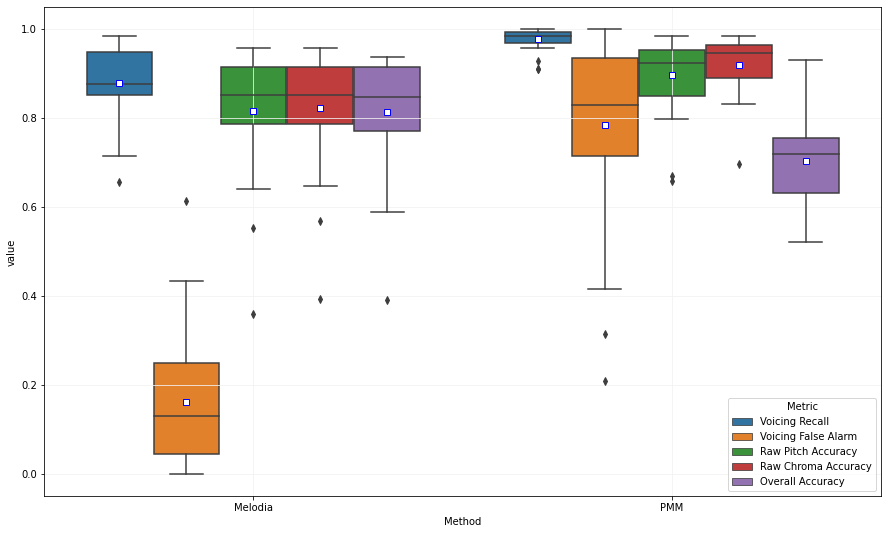

In [ ]:
# If you skip this line the plot doesn't work
%matplotlib inline 

import pandas as pd
import numpy as np
import seaborn as sns

# Create dataframes of the data
data1 = pd.DataFrame(scores_list).assign(Method='Melodia')
data2 = pd.DataFrame(scores_list_pmm).assign(Method='PMM')

# Put dataframes together
cdf = pd.concat([data1, data2])    
mdf = pd.melt(cdf, id_vars=['Method'], var_name=['Metric'])

# Plot
plt.figure(figsize=[15, 9])
ax = sns.boxplot(
    x="Method", y="value",
    hue="Metric", data=mdf,
    showmeans=True, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"})  
plt.grid(axis='both', color='0.95')  
plt.show()

### 5. Printing some synthesized examples

Observing how the spectrogram of the synthesized audio and related pitch tracks can be useful for analysis and evaluation of our methodology. For that reason, we use again pieces of code from sms-tools to plot the pitch tracks on top of the spectrogram of the synthesized audio. This piece of code is designed to basically chose a sample from the Saraga Test Set, run the whole analysis/synthesis and evaluation process on this sample, and then visualize and listen to the synthesized data.

In [ ]:
separator = Separator('spleeter:2stems')

complete_filename = '/content/saraga_examples/example20.wav'

# Get synthesized audio and pitch track
synthesized_audio, pitch_track, time_stamps = generate_track(
    filename=complete_filename,
    synth_parameters=parameters,
    pitch_preproc=True,
    voicing=True,
    use_mix=False,
)

# Code for plotting the f0 contour on top of the spectrogram (taken from sms-tools)
maxplotfreq = 500.0
N = 2048
M = 2001
H = 128

plt.figure(figsize=(19, 10))
w  = get_window(parameters['window'], M)   
mX, pX = stft.stftAnal(synthesized_audio, w, N, H) 
mX = np.transpose(mX[:,:int(parameters['N']*(maxplotfreq/44100))+1])
    
#timeStamps = np.arange(mX.shape[1])*parameters['H']/float(44100)                             
binFreqs = np.arange(mX.shape[0])*44100/float(N)
    
plt.pcolormesh(time_stamps, binFreqs, mX)
plt.plot(time_stamps, pitch_track, color = 'k', linewidth=1.5)

plt.xlim([2.5, 10])
    
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.show()

# Play audio
print('===> Listen to the synthesized track:')
ipd.Audio(synthesized_audio, rate=44100)

Output hidden; open in https://colab.research.google.com to view.